In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib import colors
import seaborn as sns
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.cluster.hierarchy import linkage, leaves_list
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

### PLOT CLUSTER MAP

In [ ]:
def plot_cluster_no_noise_2d(data, cluster_labels, save_path=None, file_name=None, show_plot=True):
    # Filter non-noise data
    non_noise_indices = cluster_labels != -1
    filtered_data = data[non_noise_indices]
    filtered_labels = cluster_labels[non_noise_indices]
    
    # Create a color palette
    palette = sns.color_palette('Spectral', np.unique(filtered_labels).max() + 1) if np.unique(filtered_labels).max() > 18 else sns.color_palette('tab20', np.unique(filtered_labels).max() + 1)
    
    # Assign colors to clusters; black for noise
    colors = [palette[x] for x in filtered_labels]

    # Count data points
    num_points = filtered_data.shape[0]
    print(f"Total data points (no noise): {num_points}")

    fig = plt.figure(figsize=(8, 6))
    plt.scatter(filtered_data[:, 0], filtered_data[:, 1], c=colors, alpha=0.6, s=2, linewidths=0)

    # Plot transparency around cluster points
    for i, color in enumerate(palette):
        cluster_points = filtered_data[filtered_labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    color=color, alpha=0.0002, s=100, linewidths=0, edgecolor=color)
    
    # Create a grid for density computation
    x_min, x_max = filtered_data[:, 0].min(), filtered_data[:, 0].max()
    y_min, y_max = filtered_data[:, 1].min(), filtered_data[:, 1].max()

    # Adjust the plot range for better visualization
    x_range = (x_max - x_min) * 0.3
    y_range = (y_max - y_min) * 0.3
    x_min -= x_range
    x_max += x_range
    y_min -= y_range
    y_max += y_range

    # Set axis limits to match the density plot
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.title(f'Clusters found by HDBSCAN (No Noise)\n cluster:{num_points}, total:{data.shape[0]}', fontsize=14)

    # Add legend with cluster colors and counts outside the plot
    unique_labels = np.unique(cluster_labels[cluster_labels >= 0])
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[label], markersize=10) for label in range(len(unique_labels))]
    labels = [f'Cluster {i}' for i in unique_labels]
    plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=5)
    plt.tight_layout(pad=1.0, rect=[0, 0, 0.85, 1])  # Adjust `rect` to make space for the legend

    # Save or show the plot
    if save_path and file_name:
        plt.savefig(f"{save_path}/{file_name}")
    if show_plot:
        plt.show()
    else:
        plt.close()

In [ ]:
def plot_cluster_no_noise_3d(data, cluster_labels, save_path=None, file_name=None, show_plot=True):
    # Filter non-noise data
    non_noise_indices = cluster_labels != -1
    filtered_data = data[non_noise_indices]
    filtered_labels = cluster_labels[non_noise_indices]
    
    # Create a color palette
    palette = sns.color_palette('Spectral', np.unique(filtered_labels).max() + 1) if np.unique(filtered_labels).max() > 18 else sns.color_palette('tab20', np.unique(filtered_labels).max() + 1)

    # Assign colors to clusters; black for noise
    colors = [palette[x] for x in filtered_labels]

    # Count data points
    num_points = filtered_data.shape[0]
    print(f"Total data points (no noise): {num_points}")

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(filtered_data[:, 0], filtered_data[:, 1], filtered_data[:,2], c=colors, alpha=0.6, s=2, linewidths=0)

    # Plot transparency around cluster points
    for i, color in enumerate(palette):
        cluster_points = filtered_data[filtered_labels == i]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:,2],
                    color=color, alpha=0.0002, s=100, linewidths=0, edgecolor=color)
    
    # Create a grid for density computation
    x_min, x_max = filtered_data[:, 0].min(), filtered_data[:, 0].max()
    y_min, y_max = filtered_data[:, 1].min(), filtered_data[:, 1].max()
    z_min, z_max = filtered_data[:, 2].min(), filtered_data[:, 2].max()

    # Adjust the plot range for better visualization
    x_range = (x_max - x_min) * 0.3
    y_range = (y_max - y_min) * 0.3
    z_range = (z_max - z_min) * 0.3
    x_min -= x_range
    x_max += x_range
    y_min -= y_range
    y_max += y_range
    z_min -= z_range
    z_max += z_range

    # Set axis limits to match the density plot
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    
    plt.title(f'Clusters found by HDBSCAN (No Noise)\n cluster:{num_points}, total:{data.shape[0]}', fontsize=14)

    # Add legend with cluster colors and counts outside the plot
    unique_labels = np.unique(cluster_labels[cluster_labels >= 0])
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[label], markersize=10) for label in range(len(unique_labels))]
    labels = [f'Cluster {i}' for i in unique_labels]
    plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=5)
    plt.tight_layout(pad=1.0, rect=[0, 0, 0.85, 1])  # Adjust `rect` to make space for the legend

    # Save or show the plot
    if save_path and file_name:
        plt.savefig(f"{save_path}/{file_name}")
    if show_plot:
        plt.show()
    else:
        plt.close()

In [15]:
def plot_cluster_2d_animation(data, cluster_labels, frames_range, save_path=None, file_name=None, show_plot=True):
    # 클러스터 라벨을 프레임 순서로 나열
    unique_labels = np.unique(cluster_labels)
    num_clusters = len(unique_labels)

    # 색상 팔레트 설정: num_clusters에 따라 다른 팔레트 사용
    if num_clusters > 18:
        palette = sns.color_palette('Spectral', num_clusters)
    else:
        palette = sns.color_palette('tab20', num_clusters)

    # 라벨을 숫자로 매핑
    label_to_color = {label: palette[i] for i, label in enumerate(unique_labels) if label != -1}
    label_to_color[-1] = (0.5, 0.5, 0.5)  # 회색 지정
    # 각 프레임에 해당하는 색상을 선택
    colors = [label_to_color[label] for label in cluster_labels]
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create scatter plot for background 
    scatter = ax.scatter(data[:,0], data[:,1], c=colors, alpha=0.6, s=2, linewidths=0)
    
    # Plot transparency around cluster points
    for i, color in enumerate(palette):
        ax.scatter(data[:,0], data[:,1], 
                    color=color, alpha=0.0002, s=100, linewidths=0, edgecolor=color)
    
    # Create a grid for density computation
    x_min, x_max = data[:, 0].min(), data[:, 0].max()
    y_min, y_max =data[:, 1].min(), data[:, 1].max()

    # Adjust the plot range for better visualization
    x_range = (x_max - x_min) * 0.3
    y_range = (y_max - y_min) * 0.3
    x_min -= x_range
    x_max += x_range
    y_min -= y_range
    y_max += y_range

    # Set axis limits to match the density plot
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Set title
    ax.set_title(f'Clusters found by HDBSCAN\n, total:{data.shape[0]}', fontsize=14)
    
    # Add legend with cluster colors and counts outside the plot
    unique_labels = np.unique(cluster_labels[cluster_labels >= 0])
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[label], markersize=10) for label in range(len(unique_labels))]
    labels = [f'Cluster {i}' for i in unique_labels]
    ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=5)
    
    # Create a list of markers for each frame
    def update(frame_num):        
        # Highlight the points for the current frame (for simplicity, use the frame as an index for selection)
        # For example, frame_num corresponds to the data points at that frame, you can adjust as needed
        frame_data = data[frame_num:frame_num+1]
        ax.scatter(frame_data[:, 0], frame_data[:, 1], color='red', s=100, edgecolor='black', label="Highlighted", zorder=5)
        
        ax.set_title(f"Frame: {frame_num}")
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        ax.legend()
        
        return scatter,

    # Create the animation
    ani = FuncAnimation(fig, update, frames=np.arange(frames_range[0], frames_range[1]), repeat=False)

    # Save the animation
    if save_path and file_name:
        ani.save(f"{save_path}/{file_name}", writer='ffmpeg', fps=30)

    # Show the plot
    if show_plot:
        plt.show()
    else:
        plt.close()

### SAVE AND PLOT DENSITY MAP

In [20]:
def save_and_plot_density_map(data, cluster_labels, save_path=None, matrix_file_name=None, plot_file_name= None,
                              show_plot=True, min_density_threshold=0.01,
                              scaling=None, k=10, grid_resolution=300, expansion_factor=0.3, 
                              vmin=None, vmax=None, extent=None):
    """
    Generate a density plot or save the density matrix for HDBSCAN clustering results.
    ++ save density matrix/ save plot / scaling the input / threshold / adjust extent & vmin_vmax & grid resolution
    -- interpolation / contour / conversion unit 

    Args:
        data (ndarray): The input data (N x 2 or N x 3).
        cluster_labels (ndarray): Cluster labels from HDBSCAN (-1 for noise).
        save_path (str, optional): Directory to save the plot or matrix.
        file_name (str, optional): File name to save the plot or matrix.
        show_plot (bool, optional): Whether to show the plot. Defaults to True.
        return_matrix (bool, optional): Whether to return the density matrix instead of plotting. Defaults to False.
        min_density_threshold (float, optional): Minimum density threshold. Defaults to 0.01.
        scaling (str, optional): Scaling method ('log1p', 'arctan', or 'log1e-8').
        k (float, optional): Scaling factor for 'arctan' method. Defaults to 10.
        grid_resolution (int, optional): Resolution of the density grid. Defaults to 300.
        expansion_factor (float, optional): Expansion factor for the bounding box. Defaults to 0.3.
        vmin (float, optional): Minimum value for color scaling. Defaults to None.
        vmax (float, optional): Maximum value for color scaling. Defaults to None.
        extent (list, optional): Custom [x_min, x_max, y_min, y_max] bounds for the plot.

    Returns:
        ndarray or None: Density matrix if `return_matrix=True`, otherwise None.
    """
    # Filter non-noise data
    non_noise_indices = cluster_labels != -1
    filtered_data = data[non_noise_indices]

    if filtered_data.shape[1] == 3:
        filtered_data = filtered_data[:, :2]  # Project 3D to 2D
        print("Projecting three-dimensional data into two specific axes.")

    kde = gaussian_kde(filtered_data.T)

    # Calculate bounds with expansion if `extent` is not provided
    if extent is None:
        x_min, x_max = filtered_data[:, 0].min(), filtered_data[:, 0].max()
        y_min, y_max = filtered_data[:, 1].min(), filtered_data[:, 1].max()

        x_range = (x_max - x_min) * expansion_factor
        y_range = (y_max - y_min) * expansion_factor
        x_min -= x_range
        x_max += x_range
        y_min -= y_range
        y_max += y_range

        extent = [x_min, x_max, y_min, y_max]
        print(extent)
    else:
        x_min, x_max, y_min, y_max = extent

    # Create grid
    x_grid, y_grid = np.mgrid[x_min:x_max:complex(grid_resolution), y_min:y_max:complex(grid_resolution)]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    density = kde(positions).reshape(x_grid.shape)

    # Apply density threshold
    density[density < min_density_threshold] = np.nan
    
    # Apply scaling
    if scaling == 'log1p':
        density = np.log1p(density)
    elif scaling == 'arctan':
        density = np.arctan(k * density)
    elif scaling == 'log1e-8':
        density = np.log(density + 1e-8)

    # Save matrix if required
    if save_path and matrix_file_name:
        np.save(f"{save_path}/{matrix_file_name}", density.T)

    # Plot density map
    plt.figure(figsize=(8, 6))
    plt.imshow(density.T, origin='lower', aspect='auto',
               extent=extent, cmap='jet', vmin=vmin, vmax=vmax)

    cbar = plt.colorbar()
    cbar.set_label('Density', fontsize=12)
    
    # Add plot title and axis labels
    plt.title(f'Density Map (Threshold ≥ {min_density_threshold})', fontsize=14)
    # plt.xlabel('X-axis', fontsize=12)
    # plt.ylabel('Y-axis', fontsize=12)

    if save_path and plot_file_name:
        plt.savefig(f"{save_path}/{plot_file_name}", bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    else:
        plt.close()


### PLOT DENSITY PROBABILITY (PDF)

In [ ]:
def plot_density_probability(data, cluster_labels, save_path=None, file_name=None, 
                             show_plot=True, min_density_threshold=0.01, scaling=None, 
                             interpolation='nearest', contour=False, contour_levels=10, k =10):
    """
    Generate a density probability plot for HDBSCAN clustering results with a minimum density threshold.
    ++ interpolation / contour in total region / conversion unit / scaling the input / save plot / threshold
    -- save density matrix/ adjust extent & vmin_vmax & grid resolution

    Args:
        data (ndarray): The input data (N x 2 or N x 3).
        cluster_labels (ndarray): Cluster labels from HDBSCAN (-1 for noise).
        save_path (str, optional): Directory to save the plot.
        file_name (str, optional): File name to save the plot.
        show_plot (bool, optional): Whether to show the plot.
        min_density_threshold (float, optional): Minimum density threshold to display. Defaults to 0.01.
        scaling (str, optional): Scaling method ('log1p' or 'arctan' or 'log1e-8).
        interpolation (str, optional): Interpolation method for imshow. Defaults to 'nearest'/ 'gaussian','bicubic'.
        contour (bool, optional): Whether to add contours to the plot. Defaults to False.
        contour_levels (int, optional): Number of contour levels. Defaults to 10.

    Returns:
        None
    """
    # Filter non-noise data
    non_noise_indices = cluster_labels != -1
    filtered_data = data[non_noise_indices]

    if filtered_data.shape[1] == 3:
        filtered_data = filtered_data[:, :2]  # Project 3D to 2D
        print("Project three-dimensional data into two specific axes")
    
    kde = gaussian_kde(filtered_data.T)

    x_min, x_max = filtered_data[:, 0].min(), filtered_data[:, 0].max()
    y_min, y_max = filtered_data[:, 1].min(), filtered_data[:, 1].max()

    x_range = (x_max - x_min) * 0.3
    y_range = (y_max - y_min) * 0.3
    x_min -= x_range
    x_max += x_range
    y_min -= y_range
    y_max += y_range

    x_grid, y_grid = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    density = kde(positions).reshape(x_grid.shape)

    density[density < min_density_threshold] = np.nan  # Apply threshold

    # Apply scaling
    if scaling == 'log1p':
        density = np.log1p(density)  # log(1 + x)
    elif scaling == 'arctan':
        density = np.arctan(k * density) # Use arctan scaling with factor k
    elif scaling =='log1e-8':
        density = np.log(density + 1e-8)
    
    # Determine scaling factor (e.g., x 10^-2, x 10^-3)
    scale_factor = 10 ** np.floor(np.log10(np.nanmax(density)) - 1)
    scaled_density = density / scale_factor

    plt.figure(figsize=(8, 6))
    plt.imshow(scaled_density.T, origin='lower', aspect='auto',
               extent=[x_min, x_max, y_min, y_max], cmap='jet', interpolation=interpolation)

    cbar = plt.colorbar()
    cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*scale_factor:.2f}'))  # Set colorbar ticks format
    if scaling: 
        cbar.set_label(f'PDF (x 10^{int(np.log10(scale_factor))}), {scaling}', fontsize=12)
    else:
        cbar.set_label(f'PDF (x 10^{int(np.log10(scale_factor))})', fontsize=12)
    
    if contour:
        plt.contour(x_grid, y_grid, scaled_density, levels=contour_levels, colors='black', linewidths=0.5, alpha=0.8)
    
    # Add plot title and axis labels
    plt.title(f'Density Probability Plot (Threshold ≥ {min_density_threshold})', fontsize=14)

    if save_path and file_name:
        plt.savefig(f"{save_path}/{file_name}", bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    else:
        plt.close()


In [ ]:
def plot_density_probability_3d(data, cluster_labels, save_path=None, file_name=None, show_plot=True, min_density_threshold=0.01):
    """
    Generate a 3D density probability plot for clustering results with a minimum density threshold.

    Args:
        data (ndarray): The input data (N x 3).
        cluster_labels (ndarray): Cluster labels from HDBSCAN (-1 for noise).
        save_path (str, optional): Directory to save the plot.
        file_name (str, optional): File name to save the plot.
        show_plot (bool, optional): Whether to show the plot.
        min_density_threshold (float, optional): Minimum density threshold to display. Defaults to 0.01.

    Returns:
        None
    """
    # Filter non-noise data
    non_noise_indices = cluster_labels != -1
    filtered_data = data[non_noise_indices]

    # Perform KDE for the 3D density estimation
    kde = gaussian_kde(filtered_data.T)

    # Create a grid for density computation
    x_min, x_max = filtered_data[:, 0].min(), filtered_data[:, 0].max()
    y_min, y_max = filtered_data[:, 1].min(), filtered_data[:, 1].max()
    z_min, z_max = filtered_data[:, 2].min(), filtered_data[:, 2].max()

    # Generate a 3D grid
    x_range = (x_max - x_min) * 0.3
    y_range = (y_max - y_min) * 0.3
    z_range = (z_max - z_min) * 0.3
    x_min -= x_range
    x_max += x_range
    y_min -= y_range
    y_max += y_range
    z_min -= z_range
    z_max += z_range

    x, y, z = np.mgrid[x_min:x_max:200j, y_min:y_max:200j, z_min:z_max:200j]
    positions = np.vstack([x.ravel(), y.ravel(), z.ravel()])
    density = kde(positions).reshape(x.shape)

    # Apply density threshold
    density[density < min_density_threshold] = np.nan  # Set values below threshold to NaN (not displayed)

    # Visualize the density with a 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x, y, z, c=density.ravel(), cmap='jet', s=1, alpha=0.8)

    plt.title(f'3D Density Probability Plot (Threshold ≥ {min_density_threshold})', fontsize=14)

    # Save or show the plot
    if save_path and file_name:
        plt.savefig(f"{save_path}/{file_name}", bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    else:
        plt.close()


In [ ]:
def plot_density_with_contours(data, cluster_labels, save_path=None, file_name=None,
                                show_plot=True, threshold=0.01, scaling=None, contour_levels=5, k=10):
    """
    Generate a density probability plot with cluster-specific contours.
    ++ save plot / scaling the input / threshold / contour in each cluster
    -- save density matrix/ interpolation / conversion unit / adjust extent & vmin_vmax & grid resolution

    Args:
        data (ndarray): The input data (N x 2).
        cluster_labels (ndarray): Cluster labels from HDBSCAN (-1 for noise).
        save_path (str, optional): Directory to save the plot.
        file_name (str, optional): File name to save the plot.
        show_plot (bool, optional): Whether to show the plot.

    Returns:
        None
    """
    # Filter non-noise data
    non_noise_indices = cluster_labels != -1
    filtered_data = data[non_noise_indices]
    filtered_labels = cluster_labels[non_noise_indices]

    # Forced conversion to 2D
    if filtered_data.shape[1] == 3:
        filtered_data = filtered_data[:, :2]  # 첫 두 축만 선택
        print("Project three-dimensional data into two specific axes")
        
    # Perform KDE for the 2D density estimation
    kde = gaussian_kde(filtered_data.T)
    x_min, x_max = filtered_data[:, 0].min(), filtered_data[:, 0].max()
    y_min, y_max = filtered_data[:, 1].min(), filtered_data[:, 1].max()

    # Adjust the plot range for better visualization
    x_range = (x_max - x_min) * 0.3
    y_range = (y_max - y_min) * 0.3
    x_min -= x_range
    x_max += x_range
    y_min -= y_range
    y_max += y_range

    x_grid, y_grid = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    density = kde(positions).reshape(x_grid.shape)
    
    # Apply threshold to remove low-density regions
    density[density < threshold] = np.nan

    # Apply scaling
    if scaling == 'log1p':
        density = np.log1p(density)  # log(1 + x)
    elif scaling == 'arctan':
        density = np.arctan(k * density) # Use arctan scaling with factor k
    elif scaling =='log1e-8':
        density = np.log(density + 1e-8)

    # Plot density
    plt.figure(figsize=(10, 8))
    plt.imshow(density.T, origin='lower', aspect='auto',
               extent=[x_min, x_max, y_min, y_max], cmap='jet', alpha=0.8)
    plt.colorbar(label=f'PDF({scaling})')
    plt.title(f'Density Probability Plot with Cluster Contours (Threshold ≥ {threshold})')

    # Plot contours for each cluster
    for cluster_id in np.unique(filtered_labels):
        cluster_points = filtered_data[filtered_labels == cluster_id]
        cluster_kde = gaussian_kde(cluster_points.T)
        cluster_density = cluster_kde(positions).reshape(x_grid.shape)
        
        # Apply the same threshold to the cluster density
        cluster_density[cluster_density < threshold] = np.nan

        plt.contour(x_grid, y_grid, cluster_density, levels=contour_levels, alpha=0.7,
                    colors='black', linewidths=0.7, linestyles='dotted')

    # Save or show the plot
    if save_path and file_name:
        plt.savefig(f"{save_path}/{file_name}")
    if show_plot:
        plt.show()
    else:
        plt.close()


In [ ]:
def plot_density_with_contours_pair(data, cluster_labels, save_path=None, file_name=None,
                                    show_plot=True, threshold=0.01, scaling=None, 
                                    contour_levels=5, k=10):
    """
    Generate density probability plots for two halves of the data with consistent scaling and extents,
    including cluster-specific contours.

    ++ save plot / scaling the input / threshold / contour in each cluster
    -- save density matrix/ interpolation / conversion unit / adjust extent & vmin_vmax & grid resolution

    Args:
        data (ndarray): The input data (N x 2).
        cluster_labels (ndarray): Cluster labels from HDBSCAN (-1 for noise).
        save_path (str, optional): Directory to save the plot.
        file_name (str, optional): File name to save the plot.
        show_plot (bool, optional): Whether to show the plot.
    
    Returns:
        None
    """
    # Split data into two halves
    half_idx = len(data) // 2
    data_1, data_2 = data[:half_idx], data[half_idx:]
    labels_1, labels_2 = cluster_labels[:half_idx], cluster_labels[half_idx:]

    # Compute density and extents for the first half
    def compute_density_and_contours(data_subset, labels_subset, global_extent):
        non_noise_indices = labels_subset != -1
        filtered_data = data_subset[non_noise_indices]
        filtered_labels = labels_subset[non_noise_indices]
        
        kde = gaussian_kde(filtered_data.T)
        x_min, x_max, y_min, y_max = global_extent

        x_grid, y_grid = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
        positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
        density = kde(positions).reshape(x_grid.shape)
        
        # Apply threshold
        density[density < threshold] = np.nan

        # Apply scaling
        if scaling == 'log1p':
            density = np.log1p(density)
        elif scaling == 'arctan':
            density = np.arctan(k * density)
        elif scaling == 'log1e-8':
            density = np.log(density + 1e-8)

        # Compute cluster contours
        contours = []
        for cluster_id in np.unique(filtered_labels):
            cluster_points = filtered_data[filtered_labels == cluster_id]
            cluster_kde = gaussian_kde(cluster_points.T)
            cluster_density = cluster_kde(positions).reshape(x_grid.shape)
            cluster_density[cluster_density < threshold] = np.nan
            contours.append((x_grid, y_grid, cluster_density))

        return density, contours

    # Determine global extent (shared range for both plots)
    x_min = min(data[:, 0].min(), data[:, 0].max())
    x_max = max(data[:, 0].min(), data[:, 0].max())
    y_min = min(data[:, 1].min(), data[:, 1].max())
    y_max = max(data[:, 1].min(), data[:, 1].max())

    # Add a margin for better visualization
    x_range = (x_max - x_min) * 0.3
    y_range = (y_max - y_min) * 0.3
    global_extent = (x_min - x_range, x_max + x_range, y_min - y_range, y_max + y_range)

    # Compute density and contours for each half
    density_1, contours_1 = compute_density_and_contours(data_1, labels_1, global_extent)
    density_2, contours_2 = compute_density_and_contours(data_2, labels_2, global_extent)

    # Set vmin and vmax for consistent color scale
    vmin = min(np.nanmin(density_1), np.nanmin(density_2))
    vmax = max(np.nanmax(density_1), np.nanmax(density_2))

    # Plot the first half
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(density_1.T, origin='lower', aspect='auto', extent=global_extent, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar(label=f'PDF({scaling})')
    plt.title("WT Half Density")
    #plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add cluster contours
    for x_grid, y_grid, cluster_density in contours_1:
        plt.contour(x_grid, y_grid, cluster_density, levels=contour_levels, alpha=0.7,
                    colors='black', linewidths=0.7, linestyles='dotted')

    # Plot the second half
    plt.subplot(1, 2, 2)
    plt.imshow(density_2.T, origin='lower', aspect='auto', extent=global_extent, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar(label=f'PDF({scaling})')
    plt.title("AD Half Density")
    #plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add cluster contours
    for x_grid, y_grid, cluster_density in contours_2:
        plt.contour(x_grid, y_grid, cluster_density, levels=contour_levels, alpha=0.7,
                    colors='black', linewidths=0.7, linestyles='dotted')

    if save_path and file_name:
        plt.savefig(f"{save_path}/{file_name}")
    if show_plot:
        plt.show()
    else:
        plt.close()



In [ ]:
def plot_density_with_contours_triplet(data, cluster_labels, save_path=None, file_name=None,
                                       show_plot=True, threshold=0.01, scaling=None, 
                                       contour_levels=5, k=10):
    """
    Generate density probability plots for the whole dataset and two halves with consistent scaling and extents,
    including shared cluster-specific contours.
    ++ save plot / scaling the input / threshold / contour in each cluster
    -- save density matrix/ interpolation / conversion unit / adjust extent & vmin_vmax & grid resolution

    Args:
        data (ndarray): The input data (N x 2).
        cluster_labels (ndarray): Cluster labels from HDBSCAN (-1 for noise).
        save_path (str, optional): Directory to save the plot.
        file_name (str, optional): File name to save the plot.
        show_plot (bool, optional): Whether to show the plot.
    
    Returns:
        None
    """
    # Split data into two halves
    half_idx = len(data) // 2
    data_1, data_2 = data[:half_idx], data[half_idx:]
    labels_1, labels_2 = cluster_labels[:half_idx], cluster_labels[half_idx:]

    # Function to compute density and contours
    def compute_density_and_contours(data_subset, labels_subset, global_extent):
        non_noise_indices = labels_subset != -1
        filtered_data = data_subset[non_noise_indices]
        filtered_labels = labels_subset[non_noise_indices]
        
        kde = gaussian_kde(filtered_data.T)
        x_min, x_max, y_min, y_max = global_extent

        x_grid, y_grid = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
        positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
        density = kde(positions).reshape(x_grid.shape)
        
        # Apply threshold
        density[density < threshold] = np.nan

        # Apply scaling
        if scaling == 'log1p':
            density = np.log1p(density)
        elif scaling == 'arctan':
            density = np.arctan(k * density)
        elif scaling == 'log1e-8':
            density = np.log(density + 1e-8)

        # Compute cluster contours
        contours = []
        for cluster_id in np.unique(filtered_labels):
            cluster_points = filtered_data[filtered_labels == cluster_id]
            cluster_kde = gaussian_kde(cluster_points.T)
            cluster_density = cluster_kde(positions).reshape(x_grid.shape)
            cluster_density[cluster_density < threshold] = np.nan
            contours.append((x_grid, y_grid, cluster_density))

        return density, contours

    # Determine global extent (shared range for all plots)
    x_min = data[:, 0].min()
    x_max = data[:, 0].max()
    y_min = data[:, 1].min()
    y_max = data[:, 1].max()

    # Add a margin for better visualization
    x_range = (x_max - x_min) * 0.3
    y_range = (y_max - y_min) * 0.3
    global_extent = (x_min - x_range, x_max + x_range, y_min - y_range, y_max + y_range)

    # Compute shared cluster contours from the whole dataset
    _, global_contours = compute_density_and_contours(data, cluster_labels, global_extent)
    
    # Compute density for the whole dataset
    density_all, _ = compute_density_and_contours(data, cluster_labels, global_extent)
    
    # Compute density for each half
    density_1, _ = compute_density_and_contours(data_1, labels_1, global_extent)
    density_2, _ = compute_density_and_contours(data_2, labels_2, global_extent)

    # Set vmin and vmax for consistent color scale
    vmin = min(np.nanmin(density_all), np.nanmin(density_1), np.nanmin(density_2))
    vmax = max(np.nanmax(density_all), np.nanmax(density_1), np.nanmax(density_2))

    # Plot the whole dataset
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(density_all.T, origin='lower', aspect='auto', extent=global_extent, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar(label=f'PDF({scaling})')
    plt.title("Whole Dataset Density")
    #plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add shared cluster contours
    for x_grid, y_grid, cluster_density in global_contours:
        plt.contour(x_grid, y_grid, cluster_density, levels=contour_levels, alpha=0.7,
                    colors='black', linewidths=0.7, linestyles='dotted')

    # Plot the first half
    plt.subplot(1, 3, 2)
    plt.imshow(density_1.T, origin='lower', aspect='auto', extent=global_extent, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar(label=f'PDF({scaling})')
    plt.title("WT Density")
    #plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add shared cluster contours
    for x_grid, y_grid, cluster_density in global_contours:
        plt.contour(x_grid, y_grid, cluster_density, levels=contour_levels, alpha=0.7,
                    colors='black', linewidths=0.7, linestyles='dotted')

    # Plot the second half
    plt.subplot(1, 3, 3)
    plt.imshow(density_2.T, origin='lower', aspect='auto', extent=global_extent, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar(label=f'PDF({scaling})')
    plt.title("AD Density")
    #plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add shared cluster contours
    for x_grid, y_grid, cluster_density in global_contours:
        plt.contour(x_grid, y_grid, cluster_density, levels=contour_levels, alpha=0.7,
                    colors='black', linewidths=0.7, linestyles='dotted')

    if save_path and file_name:
        plt.savefig(f"{save_path}/{file_name}")
    if show_plot:
        plt.show()
    else:
        plt.close()

### PlOT FEATURE-FREQUENCY MATRIX IN EACH CLUSTER

In [ ]:
def add_brackets(ax, feature_ranges, labels, x_position=-0.5, bracket_width=0.1):
    """
    Add brackets to group y-axis labels.

    Args:
        ax: Matplotlib axis.
        feature_ranges: List of tuples indicating (start, end) indices for grouping.
        labels: List of labels for each group.
        x_position: X-axis position for the bracket.
        bracket_width: Width of the bracket.
    """
    for (start, end), label in zip(feature_ranges, labels):
        # Adjust the y positions slightly if needed (for example, increase the vertical span)
        adjusted_start = start - 0.5  # Reduce the start to make the bracket slightly lower
        adjusted_end = end - 0.5    # Increase the end to make the bracket slightly higher
        
        # Draw the bracket
        ax.plot(
            [x_position, x_position - bracket_width, x_position - bracket_width, x_position],
            [adjusted_start, adjusted_start, adjusted_end, adjusted_end],
            color='black', lw=1.6
        )
        # Add the label
        ax.text(
            x_position - bracket_width - 0.1, (adjusted_start + adjusted_end) / 2, label,
            ha='right', va='center', fontsize=8
        )

def plot_feature_frequency_matrix(cwt_data, n_frequency, cluster_labels, selected_features,
                                   selected_cluster, feature_ranges=None, labels=None, mean=True):
    """
    Plot the feature-frequency matrix for specific clusters and features.

    Args:
        cwt_data (np.ndarray): Loaded CWT amplitude data (n_frames,n_frequency * n_features).
        n_frequency (np.ndarray): 1D array of frequency values (e.g., from 1 to 20 with step 1).
        cluster_labels (np.ndarray): Array of cluster labels (n_frames,).
        selected_features (list): List of feature indices to focus on.
        selected_cluster (int): The cluster label to focus on.
        feature_ranges (list of tuples, optional): List of (start, end) indices for feature groupings.
        labels (list, optional): List of labels for feature groupings.
        mean (bool): Whether to average across the cluster. Default is True.
    """
    # Set default feature_ranges and labels if not provided
    if feature_ranges is None:
        feature_ranges = [
            (0, 3), (3, 6), (6, 9), (9, 12), (12, 15), (15, 18), (18, 21),
            (21, 24), (24, 27), (27, 30), (30, 34), (34, 37)
        ]
    if labels is None:
        labels = [f"Group {i+1}" for i in range(len(feature_ranges))]

    # List to hold all the averaged data for each feature
    all_feature_data = []

    # Iterate over each selected feature
    for feature_idx in selected_features:
        # Calculate the starting and ending indices for the current feature
        start_idx = feature_idx
        step = len(selected_features)  # feature를 건너뛰기 위해
        feature_data = cwt_data[:, start_idx::step][:, :len(n_frequency)]

        # Get the time indices corresponding to the selected cluster
        cluster_indices = np.where(cluster_labels == selected_cluster)[0]

        # Extract the data for the selected cluster
        cluster_data = feature_data[cluster_indices, :]
        
        if mean: 
            # Calculate the average across the cluster's time points
            cluster_data_avg = np.mean(cluster_data, axis=0)  # Averaging across the time points in the cluster

            # Append the averaged data for this feature to the list
            all_feature_data.append(cluster_data_avg)
        else:
            all_feature_data.append(cluster_data)

    # Convert the list of all feature data to a 2D array
    all_feature_data = np.vstack(all_feature_data)  # Stack vertically (features as rows)
    
    # Plot the frequency-time matrix for all selected features
    plt.figure(figsize=(6, 4))
    plt.imshow(np.log(all_feature_data + 1), aspect='auto', origin='lower', cmap='viridis', 
    interpolation='nearest', vmin=0, vmax=0.085)
    plt.colorbar(label='Magnitude')
    plt.title(f'Cluster {selected_cluster}')
    plt.xlabel('Frequency')

    # Set custom y-axis labels (currently invisible for better visualization of brackets)
    plt.yticks([])  # Clear the y-ticks (they will be added with brackets)
    plt.ylabel('Features', labelpad=20)
    
    # Add brackets
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Add brackets with labels
    add_brackets(ax, feature_ranges, labels, x_position=-0.5, bracket_width=0.3)
    
    # Adjust the left margin to make space for brackets
    plt.subplots_adjust(left=0.0, right=0.85)
    
    # Set x-axis ticks to be spaced by 1 unit
    plt.xticks(np.arange(0, len(n_frequency), step=1),labels=n_frequency)  # Set ticks at intervals of 1
    
    # Tight layout to ensure no clipping
    plt.tight_layout()
    plt.show()


### COMMAND

In [3]:
umapspace = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/umap/umap_space_40_0.1_eu.npy')
cluster_labels = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf/soft_labels_leaf_500.npy')
save_path = '/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf'
#filename1 = 'umapdata_2d_leaf_500.png'
#plot_cluster_no_noise_2d(umapspace, cluster_labels, save_path=save_path, file_name=filename1, show_plot=True)

In [16]:
save_path= '/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug3/etc'
plot_cluster_2d_animation(umapspace, cluster_labels, (364800,365000), save_path, file_name='clusterani.mp4', show_plot=False)

/tmp/ipykernel_294608/3997631438.py:73: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ani.save(f"{save_path}/{file_name}", writer='ffmpeg', fps=30)


In [ ]:
# plot_density_probability(umapspace, cluster_labels, save_path=None, file_name=None, 
#                              show_plot=True, min_density_threshold=0.0001, scaling='arctan', 
#                              interpolation='nearest', contour=False, contour_levels=5, k =15)
plot_density_probability(umapspace, cluster_labels, save_path=None, file_name=None, 
                             show_plot=True, min_density_threshold=0.0001, scaling='arctan', 
                             interpolation='nearest', contour=True, contour_levels=40, k =30)
plot_density_probability(umapspace, cluster_labels, save_path=None, file_name=None, 
                             show_plot=True, min_density_threshold=0.0001, scaling='arctan', 
                             interpolation='nearest', contour=True, contour_levels=50, k =30)


In [ ]:
plot_density_with_contours(umapspace, cluster_labels, save_path=None, file_name=None,
                                show_plot=True, threshold=0.0001, scaling='arctan',contour_levels=5, k=30)

In [ ]:
plot_density_with_contours_pair(umapspace, cluster_labels, save_path=None, file_name=None,
                                show_plot=True, threshold=0.0001, scaling=None,contour_levels=5, k=30)

In [ ]:
plot_density_with_contours_triplet(umapspace, cluster_labels, save_path=None, file_name=None,
                                show_plot=True, threshold=0.0001, scaling=None,contour_levels=5, k=30)

In [ ]:
save_and_plot_density_map(umapspace, cluster_labels,save_path='/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf',
                          matrix_file_name='Whole_density.npy',show_plot=True,min_density_threshold=0.0001,
                              scaling=None, grid_resolution=300, expansion_factor=0.0, 
                              vmin=None, vmax=None, extent=None)

[-12.373821258544922, 12.855754852294922, -11.097640991210938, 10.153497695922852]


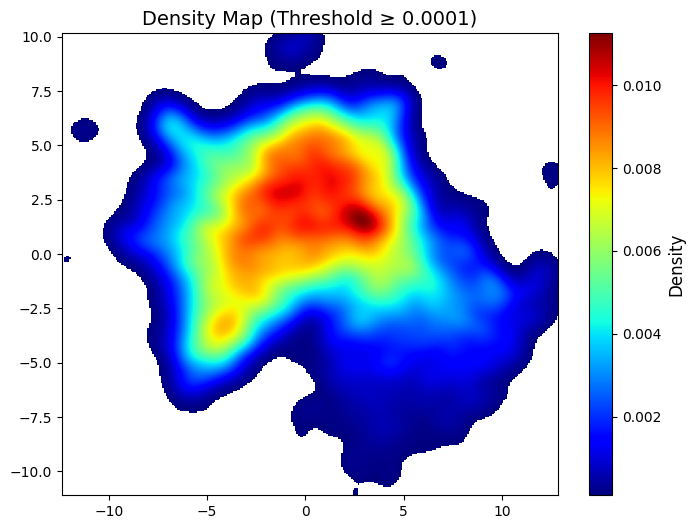

In [25]:
save_and_plot_density_map(umapspace[:249825], cluster_labels[:249825],save_path='/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf',
                          matrix_file_name='WT_density.npy',min_density_threshold=0.0001,
                              scaling=None, grid_resolution=300, expansion_factor=0.0, 
                              vmin=None, vmax=None, extent=None)

[-12.851364135742188, 12.119110107421875, -13.855514526367188, 11.509846687316895]


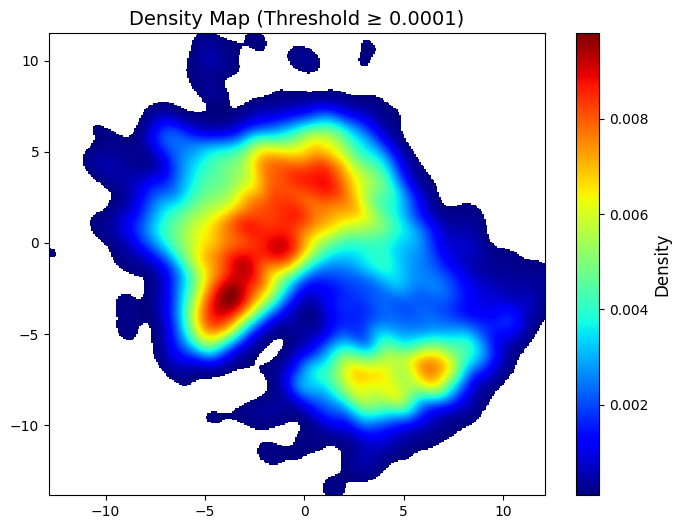

In [26]:
save_and_plot_density_map(umapspace[249825:], cluster_labels[249825:],save_path='/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf',
                          matrix_file_name='AD_density.npy',min_density_threshold=0.0001,
                              scaling=None, grid_resolution=300, expansion_factor=0.0, 
                              vmin=None, vmax=None, extent=None)

In [ ]:
chunk_size = 49965
num_chunks = len(umapspace) // chunk_size

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = start_idx + chunk_size
    
    # 데이터와 레이블을 슬라이싱
    chunk_umap = umapspace[start_idx:end_idx]
    chunk_labels = cluster_labels[start_idx:end_idx]
    
    # 파일명 설정: WT1_density.npy부터 WT5_density.npy, AD1_density.npy부터 AD5_density.npy
    if i < 5:
        matrix_file_name = f"WT{i+1}_density.npy"
    else:
        matrix_file_name = f"AD{i-4}_density.npy"
    
    # save_and_plot_density_map 함수 호출
    save_and_plot_density_map(
        chunk_umap, chunk_labels,
        save_path='/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf',
        matrix_file_name=matrix_file_name,
        show_plot=True, 
        min_density_threshold=0.0001,
        scaling=None, 
        grid_resolution=300, 
        expansion_factor=0.0, 
        vmin=None, vmax=None, 
        extent=[-12.851364135742188, 12.855754852294922, -13.855514526367188, 11.509846687316895]
    )

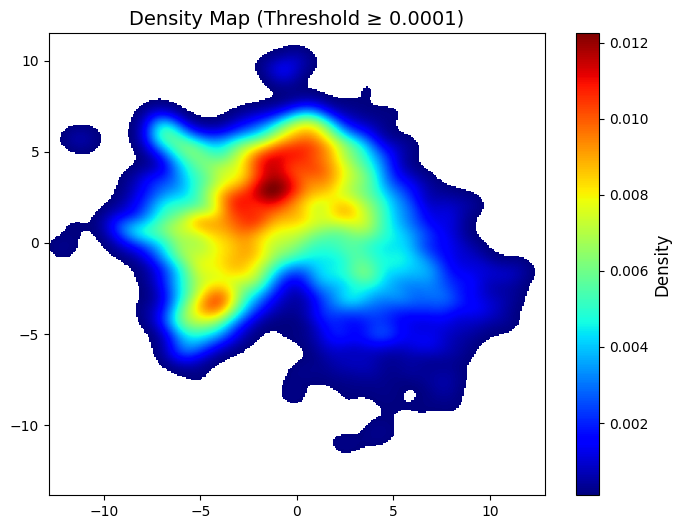

In [21]:

save_and_plot_density_map(
    umapspace[:99930],cluster_labels[:99930],
    save_path='/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf',
    matrix_file_name='WT_7M_density.npy',
    show_plot=True, 
    min_density_threshold=0.0001,
    scaling=None, 
    grid_resolution=300, 
    expansion_factor=0.0, 
    vmin=None, vmax=None, 
    extent=[-12.851364135742188, 12.855754852294922, -13.855514526367188, 11.509846687316895]
)

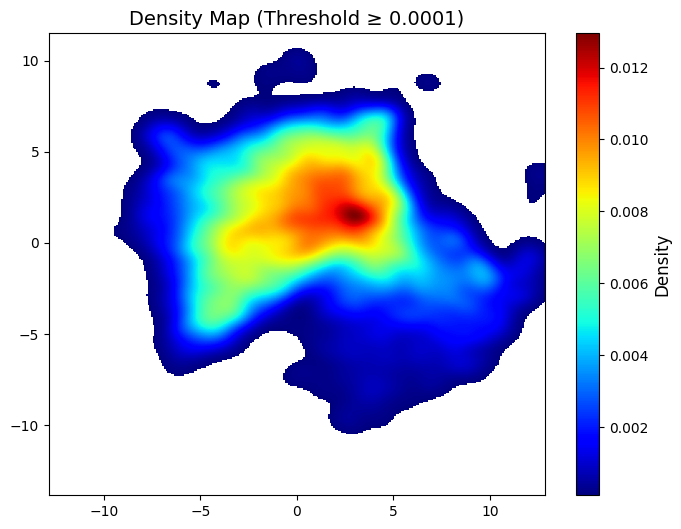

In [22]:
save_and_plot_density_map(
    umapspace[99930:249825],cluster_labels[99930:249825],
    save_path='/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf',
    matrix_file_name='WT_8M_density.npy',
    show_plot=True, 
    min_density_threshold=0.0001,
    scaling=None, 
    grid_resolution=300, 
    expansion_factor=0.0, 
    vmin=None, vmax=None, 
    extent=[-12.851364135742188, 12.855754852294922, -13.855514526367188, 11.509846687316895]
)

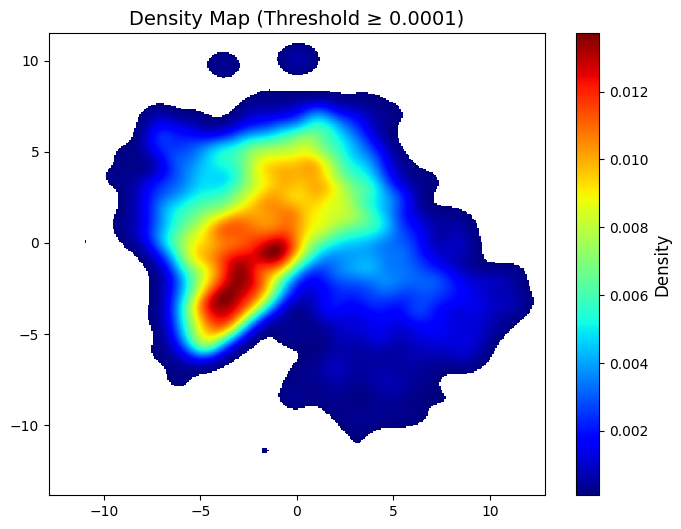

In [23]:
save_and_plot_density_map(
    umapspace[249825:349755],cluster_labels[249825:349755],
    save_path='/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf',
    matrix_file_name='AD_7M_density.npy',
    show_plot=True, 
    min_density_threshold=0.0001,
    scaling=None, 
    grid_resolution=300, 
    expansion_factor=0.0, 
    vmin=None, vmax=None, 
    extent=[-12.851364135742188, 12.855754852294922, -13.855514526367188, 11.509846687316895]
)

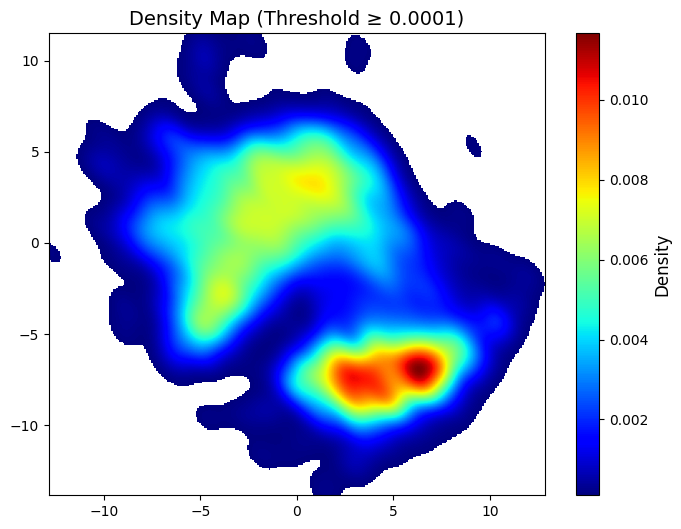

In [24]:
save_and_plot_density_map(
    umapspace[349755:],cluster_labels[349755:],
    save_path='/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf',
    matrix_file_name='AD_8M_density.npy',
    show_plot=True, 
    min_density_threshold=0.0001,
    scaling=None, 
    grid_resolution=300, 
    expansion_factor=0.0, 
    vmin=None, vmax=None, 
    extent=[-12.851364135742188, 12.855754852294922, -13.855514526367188, 11.509846687316895]
)

In [ ]:
# 데이터 로드
cwt_data = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/cwt/cwt_1_20_1_True.npy')  # shape: (n_frames, sum_features) no filtered data
n_frequency = np.arange(1, 21, 1) # 1~20, step1
cluster_labels = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf/soft_labels_leaf_500.npy')

cwt_data = cwt_data.T
cwt_WTdata = cwt_data[:249825,:]
cwt_ADdata = cwt_data[249825:,:]
cluster_WTlabels = cluster_labels[:249825]
cluster_ADlabels = cluster_labels[249825:]

# 예시로 feature 28부터 36까지 선택하고, 클러스터 0을 선택
#selected_features = list(range(28, 37))  # Feature 28부터 36까지 선택
#selected_features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,35,36]
selected_features = list(range(0, 37))
#selected_features = [0,3,6,9,12,15,18,21,24,27,35,36]
#selected_features = [34,35,36]
selected_cluster = 0
mean = True
feature_ranges = [
        (0, 3), (3, 6), (6, 9), (9, 12), (12, 15), (15, 18), (18, 21),
        (21, 24), (24, 27), (27, 30), (30, 34), (34, 37)
]
labels = [
    "nose", "l_ear", "r_ear", "l_fft", "r_fft",
    "l_hft", "r_hft", "top_tail", "mid_tail", "end_tail",
    "position", "angle"
]

# 함수 호출
#plot_feature_frequency_matrix(cwt_data.T, n_frequency, cluster_labels, selected_features, selected_cluster, mean)
for i in range(5):
    plot_feature_frequency_matrix(cwt_data, n_frequency, cluster_labels, selected_features, i, 
                                  feature_ranges,labels, mean)
    plot_feature_frequency_matrix(cwt_WTdata, n_frequency, cluster_WTlabels, selected_features, i, 
                                  feature_ranges,labels, mean)
    plot_feature_frequency_matrix(cwt_ADdata, n_frequency, cluster_ADlabels, selected_features, i, 
                                  feature_ranges,labels, mean)

In [ ]:
##### UMAP SPACE w/ FEATURES
umapspace = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/umap/umap_space_40_0.1_eu.npy')
preprocess_data = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/preprocess_True_True_True_True.npy')

features = preprocess_data[:,-7:-3]

# 각 feature에 대해 UMAP 2D 공간에 색을 매핑하여 그리기
fig, axes = plt.subplots(1, features.shape[1], figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.scatter(umapspace[:, 0], umapspace[:, 1], c=features[:, i], cmap='viridis', alpha=0.6, s=0.5)
    ax.set_title(f"Feature {i+1}")
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    fig.colorbar(ax.collections[0], ax=ax, label=f"Feature {i+1} Value")

plt.tight_layout()
plt.show()

### etc

In [ ]:
filename3 = 'umapdata_2d_pdf_leaf_500_root.png'
filename4 = 'umapdata_2d_contour_leaf_500.png'
plot_density_probability(umapspace, cluster_labels, save_path=save_path, file_name=filename3,
                         show_plot=True, min_density_threshold=0.00001)
plot_density_with_contours(umapspace, cluster_labels, save_path=None, file_name=None, show_plot=True, threshold=0.00001)


In [ ]:
plot_density_probability_3d(umapspace, cluster_labels, show_plot=True, min_density_threshold=0.00001)
plot_density_probability(umapspace, cluster_labels, show_plot=True, min_density_threshold=0.00001)
plot_density_with_contours(umapspace, cluster_labels, save_path=None, file_name=None, show_plot=True)

In [ ]:
# slide p 33, up
umapspace = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug/umap/umap_space_20_0.1_eu.npy')
cluster_labels = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug/hdbscan_leaf_150/pdf/labeldata_2d_leaf_500.npy')
save_path = '/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug/hdbscan_leaf_150/pdf'
filename1 = 'umapdata_2d_leaf_500.png'
filename2 = 'umapdata_3d_leaf_500.png'
# plot_cluster_no_noise_2d(umapspace, cluster_labels, save_path=save_path, file_name=filename1, show_plot=True)
# plot_cluster_no_noise_3d(umapspace, cluster_labels, save_path=save_path, file_name=filename2, show_plot=True)
plot_density_probability_3d(umapspace, cluster_labels, show_plot=True, min_density_threshold=0.00001)
# plot_density_probability(umapspace, cluster_labels, show_plot=True, min_density_threshold=0.00001)
# plot_density_with_contours(umapspace, cluster_labels, save_path=None, file_name=None, show_plot=True)

In [ ]:
# slide p 33, down
umapspace = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug/umap/umap_space_20_0.1_eu.npy')
cluster_labels = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug/hdbscan_eom_150/pdf/labeldata_2d_eom_500.npy')
save_path = '/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug/hdbscan_eom_150/pdf'
filename1 = 'umapdata_2d_eom_500.png'
filename2 = 'umapdata_3d_eom_500.png'
plot_cluster_no_noise_2d(umapspace, cluster_labels, save_path=save_path, file_name=filename1, show_plot=True)
plot_cluster_no_noise_3d(umapspace, cluster_labels, save_path=save_path, file_name=filename2, show_plot=True)
#plot_density_probability_3d(umapspace, cluster_labels, show_plot=True, min_density_threshold=0.00001)
plot_density_probability(umapspace, cluster_labels, show_plot=True, min_density_threshold=0.00001)
plot_density_with_contours(umapspace, cluster_labels, save_path=None, file_name=None, show_plot=True)

In [ ]:
# slide p 37, up
umapspace = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/umap/umap_space_40_0.1_eu.npy')
cluster_labels = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_eom/pdf/soft_labels_eom_500.npy')
save_path = '/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_eom/pdf'
filename1 = 'umapdata_2d_eom_500.png'

plot_cluster_no_noise_2d(umapspace, cluster_labels, save_path=save_path, file_name=filename1, show_plot=True)
plot_density_probability(umapspace, cluster_labels, show_plot=True, min_density_threshold=0.00001)
plot_density_with_contours(umapspace, cluster_labels, save_path=None, file_name=None, show_plot=True)

In [ ]:
# slide p 37, down
umapspace = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/umap/umap_space_40_0.1_eu.npy')
cluster_labels = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf/soft_labels_leaf_500.npy')
save_path = '/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/hdbscan_leaf/pdf'
filename1 = 'umapdata_2d_leaf_500.png'

plot_cluster_no_noise_2d(umapspace, cluster_labels, save_path=save_path, file_name=filename1, show_plot=True)
plot_density_probability(umapspace, cluster_labels, show_plot=True, min_density_threshold=0.00001)
plot_density_with_contours(umapspace, cluster_labels, save_path=None, file_name=None, show_plot=True)

In [ ]:
data = np.load("/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug/hdbscan_eom_150/pdf/pcadata_2d_eom_500.npy")
cluster_labels = np.load("/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug/hdbscan_eom_150/pdf/labeldata_2d_eom_500.npy")
save_path = '/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug/hdbscan_eom_150/pdf'
file_name = 'pdf_pca_eom_380.png'
plot_cluster_no_noise_2d(data, cluster_labels, save_path=None, file_name=None, show_plot=True)
plot_density_probability(data, cluster_labels, show_plot=True, min_density_threshold=0.00001)
plot_density_with_boundaries(data, cluster_labels, save_path=None, file_name=None, show_plot=True)
plot_density_with_contours(data, cluster_labels, save_path=None, file_name=None, show_plot=True)